In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import logging
import os

import yaml

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import galcheat
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from pdf2image import convert_from_path

from madness_benchmark.utils import get_benchmark_config_path

mpl.rcParams["text.usetex"] = True
mpl.rcParams["savefig.dpi"] = 1200
# plt.rcParams[
#     "text.latex.preamble"
# ] = r"\usepackage{bm} \usepackage{amsmath}"  # for \text command

In [ ]:
with open(get_benchmark_config_path()) as f:
    benchmark_config = yaml.safe_load(f)
survey = galcheat.get_survey(benchmark_config["survey_name"])

In [ ]:
logging.basicConfig(format="%(message)s", level=logging.INFO)
LOG = logging.getLogger(__name__)


def format_func(value, tick_number):
    # Format the y-axis labels as integers without decimals
    return "{:.3f}".format(value)

In [ ]:
density_level = "high"

data_path = os.path.join(
    benchmark_config["RESULTS_PATH"][benchmark_config["survey_name"]],
    density_level + "_density",
)
run_name = "kl2"  # 12 to 20 galaxies
result_dir_path = os.path.join(data_path, run_name)

In [ ]:
scarlet_plot_color = sns.color_palette("colorblind")[4]
madness_plot_color = sns.color_palette("colorblind")[0]
debvader_plot_color = sns.color_palette("colorblind")[2]

isolated_plot_color = sns.color_palette("colorblind")[6]
blended_plot_color = sns.color_palette("colorblind")[1]

madness_plot_ls = "dashdot"
debvader_plot_ls = "dotted"
scarlet_plot_ls = "-"

isolated_plot_ls = "dotted"
blended_plot_ls = "--"

scarlet_plot_label = r"\textsc{scarlet}"
madness_plot_label = r"\texttt{MADNESS}"
debvader_plot_label = r"\texttt{VAE-deblender}"

In [ ]:
madness_results = []
debvader_results = []
scarlet_results = []
actual_photometry = []
blended_photometry = []

for file_num in range(300):

    madness_results.append(
        pd.read_pickle(
            os.path.join(result_dir_path, "madness_results", str(file_num) + ".pkl")
        )
    )
    debvader_results.append(
        pd.read_pickle(
            os.path.join(result_dir_path, "debvader_results", str(file_num) + ".pkl")
        )
    )
    scarlet_results.append(
        pd.read_pickle(
            os.path.join(data_path, "scarlet_results", str(file_num) + ".pkl")
        )
    )

    actual_photometry.append(
        pd.read_pickle(
            os.path.join(data_path, "actual_photometry", str(file_num) + ".pkl")
        )
    )
    blended_photometry.append(
        pd.read_pickle(
            os.path.join(data_path, "blended_photometry", str(file_num) + ".pkl")
        )
    )

madness_results = pd.concat(madness_results)
debvader_results = pd.concat(debvader_results)
scarlet_results = pd.concat(scarlet_results)

actual_photometry = pd.concat(actual_photometry)
blended_photometry = pd.concat(blended_photometry)

In [ ]:
outlier_contamination_value = 5
mask = madness_results["r_contamination"] <= outlier_contamination_value

print(f"outlier contamination cut: {outlier_contamination_value}")
print(f"using only {np.sum(mask)} out of {len(madness_results)}")
print(f"removed {len(madness_results) - np.sum(mask)} galaxies")

outlier contamination cut: 5
using only 94893 out of 95972
removed 1079 galaxies


In [ ]:
print("MADNESS average: " + str(np.mean(madness_results["r_cosd"].values[mask])))
print("VAE-deblender average: " + str(np.mean(debvader_results["r_cosd"].values[mask])))
print("scarlet average: " + str(np.mean(scarlet_results["r_cosd"].values[mask])))

MADNESS average: 0.993582515933737
VAE-deblender average: 0.9869209841462807
scarlet average: 0.9912897080482017


In [ ]:
print("MADNESS average: " + str(np.mean(madness_results["r_ssim"])))
print("VAE-deblender average: " + str(np.mean(debvader_results["r_ssim"])))
print("scarlet average: " + str(np.mean(scarlet_results["r_ssim"])))

MADNESS average: 0.9985471996245839
VAE-deblender average: 0.9975354497328184
scarlet average: 0.9977409515951264


In [ ]:
np.mean(debvader_results["r_cosd"])

0.9861181818281727

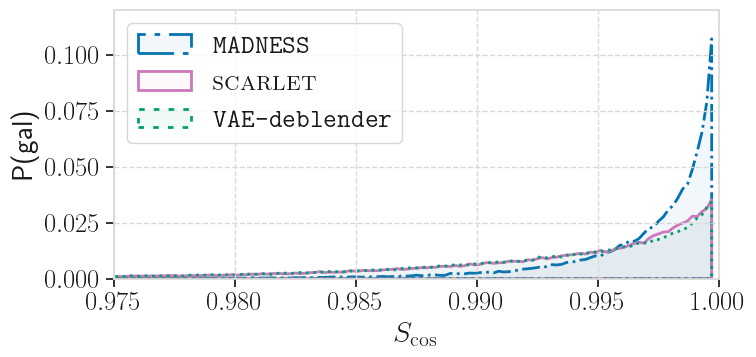

In [ ]:
bins = np.arange(0, 1, 0.0002)
text_cos = r"\text{cos}"
band = "r"

sns.set_theme(
    font_scale=1.75,
    style={
        "style": "whitegrid",
        "xtick.bottom": True,
        "axes.grid": True,
        "xtick.top": False,
        "ytick.left": True,
        "ytick.right": False,
        "text.color": ".1",
        "xtick.color": ".1",
        "ytick.color": ".1",
        "axes.edgecolor": ".85",
        "axes.labelcolor": ".1",
    },
    rc={"grid.color": ".85", "grid.linestyle": "--"},
)
plt.figure(figsize=(8, 4))


mask = np.ones(len(madness_results), dtype=bool)
sns.histplot(
    madness_results[mask][band + "_cosd"].values,
    bins=bins,
    alpha=0.05,
    label=madness_plot_label,
    color=madness_plot_color,
    element="poly",
    stat="probability",
    ls=madness_plot_ls,
    lw=2,
)
sns.histplot(
    scarlet_results[mask][band + "_cosd"].values,
    bins=bins,
    alpha=0.05,
    label=scarlet_plot_label,
    color=scarlet_plot_color,
    element="poly",
    stat="probability",
    ls=scarlet_plot_ls,
    lw=2,
)
sns.histplot(
    debvader_results[mask][band + "_cosd"].values,
    bins=bins,
    alpha=0.05,
    label=debvader_plot_label,
    color=debvader_plot_color,
    element="poly",
    stat="probability",
    ls=debvader_plot_ls,
    lw=2,
)

# plt.legend(title= fr"\textit{{{band}}}-band", loc="upper left", fontsize=15)
plt.legend(loc="upper left")

ax = plt.gca()

ax.xaxis.tick_bottom()
ax.yaxis.tick_left()
#     if band != "u":
#         ax.get_legend().remove()
plt.xlim([0.975, 1])
plt.ylim([0, 0.12])
plt.xlabel(r"$S_{\mathrm{cos}}$")
plt.ylabel("P(gal)")

plt.tight_layout()
# plt.savefig(result_dir_path + "/cosd_res_"+band)


plt.legend(loc="upper left")

plt.savefig(
    os.path.join(
        "results",
        "temp",
        "cosd_res_" + band + ".pdf",
    ),
    format="pdf",
    bbox_inches="tight",
)


plt.show()
plt.close()

## SSIM

In [ ]:
bins = np.arange(-1, 1, 0.00002)
band = "r"
plt.figure(figsize=(8, 4))
ax = plt.gca()
# ax.yaxis.set_major_formatter(ticker.StrMethodFormatter(f'{{x:.3f}}'))
#     mask = (
#         actual_photometry[band + "_phot_flux"].values
#         / actual_photometry[band + "_phot_fluxerrs"].values
#     ) > 10
mask = np.ones(len(madness_results), dtype=bool)
sns.histplot(
    madness_results[mask][band + "_ssim"].values,
    bins=bins,
    alpha=0.05,
    label=madness_plot_label,
    color=madness_plot_color,
    element="poly",
    stat="probability",
    ls=madness_plot_ls,
    lw=2,
)
sns.histplot(
    scarlet_results[mask][band + "_ssim"].values,
    bins=bins,
    alpha=0.05,
    label=scarlet_plot_label,
    color=scarlet_plot_color,
    element="poly",
    stat="probability",
    ls=scarlet_plot_ls,
    lw=2,
)
sns.histplot(
    debvader_results[mask][band + "_ssim"].values,
    bins=bins,
    alpha=0.05,
    label=debvader_plot_label,
    color=debvader_plot_color,
    element="poly",
    stat="probability",
    ls=debvader_plot_ls,
    lw=2,
)
# plt.legend(title= fr"\textit{{{band}}}-band", loc="upper left")
plt.legend(loc="upper left")

ax = plt.gca()
ax.xaxis.tick_bottom()
ax.yaxis.tick_left()
#     if band != "u":
#         ax.get_legend().remove()
plt.xlim([0.9975, 1])
plt.ylim([0, 0.075])
plt.xlabel(r"SSIM")
plt.ylabel(r"P(gal)")
plt.tight_layout()
# plt.savefig(result_dir_path + "/cosd_res_"+band)
plt.savefig(
    os.path.join("results", "temp", "ssim_res_" + band + ".pdf"),
    format="pdf",
    bbox_inches="tight",
)
plt.close()

## Combine the results

In [ ]:
f, axarr = plt.subplots(2, 1, figsize=(8, 8))


# axarr[0].imshow(mpimg.imread(os.path.join(result_dir_pth, "cumulative_distib_phot_err_r.png")))
axarr[0].imshow(convert_from_path(os.path.join("results", "temp", "ssim_res_r.pdf"))[0])
axarr[1].imshow(convert_from_path(os.path.join("results", "temp", "cosd_res_r.pdf"))[0])

# turn off x and y axis
[ax.set_axis_off() for ax in axarr.ravel()]
[ax.margins(y=0, x=0) for ax in axarr.ravel()]


plt.tight_layout(pad=0)

plt.savefig(
    os.path.join("results", "morphology_results.pdf"),
    format="pdf",
    bbox_inches="tight",
)

plt.show()